In [248]:
!pip install mne==0.21



In [249]:
import mne
mne.__version__

'0.21.0'

In [250]:
import sys
sys.path.append('../')  # noga
import os
import library
import library.models_lib.band_specific_ecog
import library.models_lib.common
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import scipy
import scipy.io
import scipy.signal
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

from torch.autograd import Variable
import torch, torch.nn as nn
import torch.nn.functional as F
import matplotlib.image as mpimg

import scipy
import sklearn
import sklearn.metrics
import math

import mne

import numpy as np
import scipy
import scipy.signal
import random
import scipy
import math
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import pandas
import numpy as np

from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler

import math

import sklearn
import sklearn.metrics

import matplotlib
import matplotlib.pyplot as plt

import copy

import scipy
import scipy.signal



from IPython.display import display, clear_output

def downsample(X, Y, frequency, x_times):
    assert x_times in range(13)
    X = scipy.signal.decimate(X, x_times, axis=0)
    Y = scipy.signal.decimate(Y, x_times, axis=0)
    return X, Y, frequency / x_times


def high_pass_filtering(X, frequency, cutoff_frequency):
    b, a = scipy.signal.butter(3, cutoff_frequency * 1.0 / (frequency * 1.0 / 2), 'high')
    for i in range(X.shape[1]):
        X[:, i] = scipy.signal.filtfilt(b, a, X[:, i])
    return X


def norch_filtering(X, Y, frequency, remove_frequency):
    QUALITY = 30
    b, a = scipy.signal.iirnotch(remove_frequency * 1.0 / (frequency * 1.0 / 2), QUALITY)
    for i in range(X.shape[1]):
        X[:, i] = scipy.signal.filtfilt(b, a, X[:, i])
    return X, Y, frequency


def data_generator(X, Y, batch_size, shuffle=True, infinite=True):
    assert len(X)==len(Y) or len(Y)==0
    total_lag = lag_backward + lag_forward
    all_batches = math.ceil((X.shape[0] )/batch_size)
    samples_in_last_batch = (X.shape[0]) % batch_size
    batch = 0
    random_core = np.arange(0, X.shape[0])
    while True:
        if shuffle:
            np.random.shuffle(random_core)
        for batch in range(all_batches):       
            batch_start = batch * batch_size
            batch_end = (batch + 1)*batch_size
            if batch_end >= len(random_core):
                batch_end = None
            batch_samples = random_core[batch_start : batch_end]

            batch_x = X[[batch_samples]]
            #batch_x = np.swapaxes(batch_x, 1, 2)

            if len(Y) > 0:
                batch_y = Y[[batch_samples]] 
                yield (batch_x, batch_y)
            else:
                yield batch_x
        
        if not infinite:
            break

In [251]:
DATA_FOLDER = "/home/amplifier/common/gurasog/Standard_dataset/"
DATA_FOLDER = "/home/amplifier/common/gurasog/Standard_dataset/Clean/"
sorted_filenames = sorted(os.listdir(DATA_FOLDER))

FREQUENCY = 160
CHANNELS_COUNT = 64


MARK_TO_STATUS = {
    
    "S001": {
        1: 'rest',
        2: 'left_hand',
        3: 'right_hand',
        
    },
                  
    "S002": {
        1: 'rest',
        2: 'left_hand',
        3: 'right_hand',
        
    },
    
    "S003": {
        1: 'rest',
        2: 'left_hand',
        3: 'right_hand',
        
    },
    
    "S004": {
        1: 'rest',
        2: 'left_hand',
        3: 'right_hand',
        
    },
    
    "S005": {
        1: 'rest',
        2: 'left_hand',
        3: 'right_hand',
        
    },
    
    "S006": {
        1: 'rest',
        2: 'left_hand',
        3: 'right_hand',
        
    },
    
    "S007": {
        1: 'rest',
        2: 'left_hand',
        3: 'right_hand',
        
    },
    
    "S008": {
        1: 'rest',
        2: 'left_hand',
        3: 'right_hand',
        
    },
    
    "S009": {
        1: 'rest',
        2: 'left_hand',
        3: 'right_hand',
        
    }


}
'''
    "S005": {
        1: 'rest',
        2: 'left_hand',
        3: 'right_hand',
        
    },
    
    "S006": {
        1: 'rest',
        2: 'left_hand',
        3: 'right_hand',
        
    },
    
    "S007": {
        1: 'rest',
        2: 'left_hand',
        3: 'right_hand',
        
    },
    
    "S008": {
        1: 'rest',
        2: 'left_hand',
        3: 'right_hand',
        
    },
    
    "S009": {
        1: 'rest',
        2: 'left_hand',
        3: 'right_hand',
        
    }
'''
    
    

STATUS_TO_LABEL = {
    'left_hand': 0,
    'right_hand': 1,
    #'left_leg': -1,
    #'right_leg': -1,
    #'pause': -1,
    #'protocol': -1,
    'rest': -1,
    'unknown': -1,
}


classes_examples_counter = {}

DATA_DICT = {}



def read_labels(labels_filename, statuses):
    labels = []
    with open(f"{DATA_FOLDER}/{labels_filename}") as input_file:
        for row in input_file:
            status = statuses.get(int(float(row.strip())), 'unknown')
            classes_examples_counter[status] = classes_examples_counter.get(status, 0) + 1
            labels.append(STATUS_TO_LABEL[status])
    return np.array(labels)

channel_names = []


In [252]:
#fif_data = mne.io.read_raw_fif(f"{DATA_FOLDER}/{data_filename}", preload=True, verbose=0)

In [253]:
#sorted_filenames=sorted_filenames[2:]

In [254]:
sorted_filenames=sorted_filenames[1:]

In [255]:
sorted_filenames

['S001ica-raw.fif',
 'S001ica.csv',
 'S002ica-raw.fif',
 'S002ica.csv',
 'S003ica-raw.fif',
 'S003ica.csv',
 'S004ica-raw.fif',
 'S004ica.csv']

In [256]:

for data_filename, labels_filename in zip(sorted_filenames[::2], sorted_filenames[1::2]):
    print(data_filename, labels_filename)
    #assert data_filename.split("_")[0] == labels_filename.split("_")[0]
    patient = data_filename[:4]
    
    fif_data = mne.io.read_raw_fif(f"{DATA_FOLDER}/{data_filename}", preload=True, verbose=0)
    fif_data.filter(3,35)
    data = fif_data.get_data().transpose()
    channel_names.append(fif_data.ch_names)
    labels = read_labels(labels_filename, MARK_TO_STATUS[patient])

    assert labels.shape[0] == data.shape[0]
    assert data.shape[1] == CHANNELS_COUNT
    
    print(patient, f"{round(data.shape[0] / FREQUENCY / 60, 1)} minutes", f"{round(sum(labels != -1) / FREQUENCY / 60, 1)} real minutes")

    DATA_DICT[patient] = (data, labels)

print()
for label, count in classes_examples_counter.items():
    print(label, f"{round(count / FREQUENCY / 60, 1)} minutes")
    
assert len(set(list(map(lambda x: "__".join(x), channel_names)))) == 1
#channel_names = channel_names[0]

S001ica-raw.fif S001ica.csv
S001 6.2 minutes 3.1 real minutes
S002ica-raw.fif S002ica.csv
S002 6.2 minutes 3.1 real minutes
S003ica-raw.fif S003ica.csv
S003 6.2 minutes 3.1 real minutes
S004ica-raw.fif S004ica.csv
S004 6.2 minutes 3.1 real minutes

rest 12.4 minutes
right_hand 6.2 minutes
left_hand 6.2 minutes


In [257]:
fif_data.info

<Info | 10 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 file_id: 4 items (dict)
 highpass: 3.0 Hz
 lowpass: 35.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 meas_id: 4 items (dict)
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
>

In [258]:
def make_lag_3D(X_3D, lag_backward, lag_forward, decimate=1):
    # TODO: probably this code can be rewritten shorter
    assert decimate > 0
    assert lag_backward >=0
    assert lag_forward >=0

    output_samples = X_3D.shape[0] - lag_backward - lag_forward
    channels = X_3D.shape[1]
    feature_per_channel = X_3D.shape[2]
    # TODO: CHECK IF ITS VALID
    features_backward = int(lag_backward / decimate)
    features_forward = int(lag_forward / decimate)
    output_features = feature_per_channel * (1 + features_forward + features_backward)

    X_output_3D = np.zeros((output_samples, channels, output_features))
    feature_index = 0
    for time_shift in range(decimate, lag_backward + decimate, decimate):
        feature_slice = slice(feature_index, feature_index + feature_per_channel)
        X_output_3D[:, :, feature_slice] = X_3D[lag_backward - time_shift:-lag_forward - time_shift]
        feature_index += feature_per_channel

    feature_slice = slice(feature_index, feature_index + feature_per_channel)
    X_output_3D[:, :, feature_slice] = X_3D[lag_backward:-lag_forward if lag_forward > 0 else None]  # cetntral point
    feature_index += feature_per_channel

    for time_shift in range(decimate, lag_forward + decimate, decimate):
        feature_slice = slice(feature_index, feature_index + feature_per_channel)
        X_output_3D[:, :, feature_slice] = X_3D[lag_backward + time_shift:-lag_forward + time_shift if lag_forward - time_shift > 0 else None]
        feature_index += feature_per_channel
    assert feature_index == output_features
    return X_output_3D


LAG_BACKWARD = 0
LAG_FOREWARD = 480


def prepare_dataset(patients_indexes):
    X = []
    Y = []
    for patient in patients_indexes:
        x = None
        y = None
        
        if patient == 0:
            hjhjhjh=0
            #data = scipy.io.loadmat("//home/amplifier/common/pet67/ossadtchi-ml-test-bench/paper/1.mat")
            #RIGHT_PAD = 1000
            #x = data['data'][:30].transpose()[:-RIGHT_PAD]
            #y = data['data'][30][:-RIGHT_PAD]
        else:
            x, y = DATA_DICT[f"S{patient}"]
        x = sklearn.preprocessing.scale(x)
        X.append(x)
        Y.append(y)

    X = np.concatenate(X, axis=0)
    Y = np.concatenate(Y, axis=0)


    X = make_lag_3D(X[:, :, None], LAG_BACKWARD, LAG_FOREWARD, 1)
    Y = Y[LAG_BACKWARD:-LAG_FOREWARD if LAG_FOREWARD > 0 else None]
    
    def all_equal(array):
        labels_set = set(array.tolist())
        return len(labels_set) == 1 and -1 not in labels_set


    good_indexes = []
    for i in range(LAG_BACKWARD + 1, Y.shape[0] - LAG_FOREWARD - 1):
        if all_equal(Y[i - LAG_BACKWARD - 1:i + LAG_FOREWARD + 1]):
            good_indexes.append(i)
    print(good_indexes)

    X = X[good_indexes]
    Y = Y[good_indexes]
    
    assert X.shape[0] == Y.shape[0], f"{X.shape[0]} != {Y.shape[0]}"
    
    return X, Y.reshape((-1, 1))

        


In [259]:
from sklearn.model_selection import train_test_split

In [260]:
aaaa=fif_data.get_data()
#aaaa[:,480:480+]

In [261]:
#aaaa[0,673:673+320]#.shape

In [262]:
#X[0,0]#.shape

In [263]:
#[aaaa[0,673:673+321][i]==X[0,0,][i] for i in range(321)]

In [264]:
#plt.plot(labels[1500:3000])

In [265]:
#labels[687:687+642]

In [266]:
X,Y = prepare_dataset(['003'])

[673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021

In [267]:
X[:,:,-1].shape

(7860, 64)

In [268]:
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2,shuffle=False)

In [18]:

X_train, Y_train = prepare_dataset(['001','002','003','004','005','006'])
X_test, Y_test = prepare_dataset(['008','009'])

KeyError: 'S005'

In [117]:

bbb=['001','002','003','004']#,'005','006','008','009']

X_train_s=[]
X_test_s=[]
Y_train_s=[]
Y_test_s=[]

for i in bbb:
    X, Y = prepare_dataset([i])
    X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2,shuffle=False)
    
    X_train_s.append(X_train)
    X_test_s.append(X_test)
    
    Y_train_s.append(Y_train)
    Y_test_s.append(Y_test)
    

[673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021

In [118]:
[X_train_s[i].shape for i in range(len(X_train_s))]

[(6288, 64, 481), (6160, 64, 481), (6288, 64, 481), (6160, 64, 481)]

In [269]:
print(len(X_train_s))
print(X_train_s[0].shape)

4
(6288, 64, 481)


In [120]:
X_train=np.concatenate(X_train_s)
X_test=np.concatenate(X_test_s)

Y_train=np.concatenate(Y_train_s)
Y_test=np.concatenate(Y_test_s)

In [121]:
X_test.shape

(6224, 64, 481)

In [122]:
X_test[0,:,:]

array([[-1.47558701, -1.21406337,  0.02627868, ...,  0.17172689,
         0.43013867,  0.69471202],
       [-1.65703289, -1.52126401, -0.50575056, ..., -0.37339536,
        -0.25073078,  0.0501194 ],
       [-1.4071914 , -1.52451336, -0.79567986, ..., -0.10505052,
        -0.25588847, -0.19474455],
       ...,
       [-0.4396047 , -0.3511265 , -0.49497016, ...,  0.27674188,
        -0.72735784, -1.73829245],
       [-0.4503234 , -0.45612166, -0.51490972, ..., -0.23795034,
        -0.76954638, -1.41095938],
       [-0.55395009, -0.4974182 , -0.70152726, ...,  0.43712833,
        -0.3445057 , -1.38152781]])

In [270]:
X_train.shape

(6288, 64, 481)

In [271]:
#plt.hist(Y_train)

In [272]:
X_test.shape

(1572, 64, 481)

In [273]:

# ntr = int(X_train.shape[0] * 0.7)

# X_test = X_train[ntr:]
# Y_test = Y_train[ntr:]

# X_train = X_train[:ntr]
# Y_train = Y_train[:ntr]


def print_dataset_info(X, Y):
    labels_conter = {}
    for label in Y[:, 0]:
        labels_conter[label] = labels_conter.get(label, 0) + 1
    for label, count in labels_conter.items():
        print(label, f"{round(count / FREQUENCY / 60, 1)} minutes")
        
print("Train info")
print_dataset_info(X_train, Y_train)

print("Test info")
print_dataset_info(X_test, Y_test)

Train info
1 0.3 minutes
0 0.3 minutes
Test info
0 0.1 minutes
1 0.1 minutes


In [274]:
# BEST_CHANNELS = [17, 12, 18, 25,  4, 13, 21, 14, 22, 27]
# X_train = X_train[:, BEST_CHANNELS]
# X_test = X_test[:, BEST_CHANNELS]

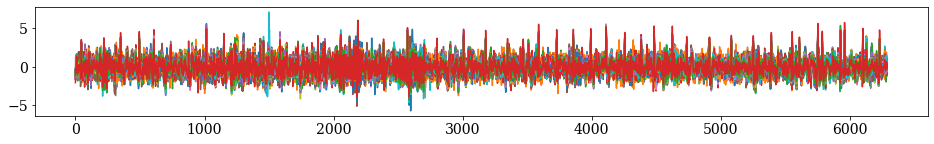

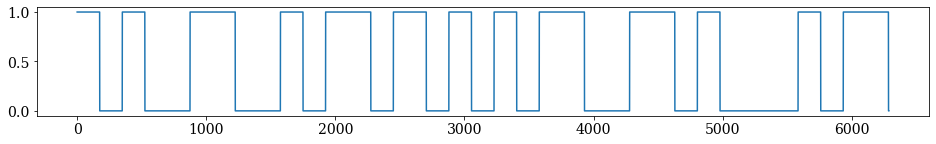

In [275]:
plt.figure(figsize=(16, 2))
plt.plot(X_train[:, :, 250])
plt.show()

plt.figure(figsize=(16, 2))
plt.plot(Y_train[:, :])
plt.show()

In [280]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class envelope_detector(nn.Module):
    def __init__(self, in_channels, channels_per_channel):
        super(self.__class__,self).__init__()
        self.FILTERING_SIZE = 50 #100
        self.ENVELOPE_SIZE = 10 #50
        self.CHANNELS_PER_CHANNEL = channels_per_channel
        self.OUTPUT_CHANNELS = self.CHANNELS_PER_CHANNEL * in_channels
        self.conv_filtering = nn.Conv1d(in_channels, self.OUTPUT_CHANNELS, bias=False, kernel_size=self.FILTERING_SIZE, groups=in_channels)
        self.conv_envelope = nn.Conv1d(self.OUTPUT_CHANNELS, self.OUTPUT_CHANNELS, kernel_size=self.ENVELOPE_SIZE, groups=self.OUTPUT_CHANNELS)
        self.conv_envelope.requires_grad = False
        self.pre_envelope_batchnorm = torch.nn.BatchNorm1d(self.OUTPUT_CHANNELS, affine=False) 
        self.relu = torch.nn.ReLU()
        self.intermidiate = None
        
        self.dropout1=nn.Dropout(p=0.3)
        self.dropout2=nn.Dropout(p=0.3)
         
        
    def forward(self, x):
        x = self.conv_filtering(self.dropout1(x))
        
        x = self.pre_envelope_batchnorm(x)
        
        #x = self.relu(x)
        x = torch.abs(x)
        x = self.conv_envelope(self.dropout2(x))
        return x
    
    


class simple_net(nn.Module):
    def __init__(self, in_channels, output_channels, lag_backward, lag_forward):
        super(self.__class__,self).__init__()
        self.ICA_CHANNELS = 15

        self.total_input_channels = self.ICA_CHANNELS
        self.lag_backward = lag_backward
        self.lag_forward = lag_forward

        self.final_out_features = 330

        self.ica = nn.Conv1d(in_channels, self.ICA_CHANNELS, 1)

        self.detector = envelope_detector(self.total_input_channels, 1)
        self.features_batchnorm = torch.nn.BatchNorm1d(self.final_out_features, affine=False)
        self.unmixed_batchnorm = torch.nn.BatchNorm1d(self.total_input_channels, affine=False)
        
        self.dropout1=nn.Dropout(p=0.3)
        self.dropout2=nn.Dropout(p=0.5)
        self.wights_second = nn.Linear(self.final_out_features, output_channels)

    def forward(self, inputs):
        all_inputs = self.ica(inputs)
        
        # print('Это вфорвард и класса 1')
        # print(all_inputs.shape)

        self.fuck_channels = all_inputs.cpu().data.numpy()
        all_inputs = self.unmixed_batchnorm(all_inputs)
        # print('Это вфорвард и класса 2')
        # print(all_inputs.shape)

        detected_envelopes = self.detector(self.dropout1(all_inputs))
        # print('Это вфорвард и класса 3')
        # print(detected_envelopes.shape)

        features  = detected_envelopes[:, :, ::20].contiguous() #прореживание огибающий - dowsampling
        # print('Это вфорвард и класса 4')
        # print(features.shape)
        
        features = features.view(features.size(0), -1)
        # print('Это вфорвард и класса 5')
        # print(features.shape)
        
        features = self.features_batchnorm(features)
        # print('Это вфорвард и класса 6')
        # print(features.shape)
        
        self.pre_out = features.cpu().data.numpy()
        # print('Это вфорвард и класса 7')
        # print(self.pre_out.shape)
        
        output = self.wights_second(self.dropout2(features))
        # print('Это вфорвард и класса 8')
        # print(output.shape)
        
        return output


In [281]:
#model = simple_net(X_train.shape[1], len(all_labels), lag_backward, lag_forward).cuda()
#model

In [282]:
X_train.shape

(6288, 64, 481)

In [ ]:
batch_size = 5000
lag_backward = LAG_BACKWARD
lag_forward = LAG_FOREWARD

all_labels = set(Y_train[:, 0].tolist()) | set(Y_test[:, 0].tolist())

model = simple_net(X_train.shape[1], len(all_labels), lag_backward, lag_forward).cuda()
#model = simple_net(X_train.shape[1], 6, lag_backward, lag_forward).cuda()

print("Trainable params: ",sum(p.numel() for p in model.parameters() if p.requires_grad))
print("Total params: ",sum(p.numel() for p in model.parameters() if p.requires_grad))
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


loss_history_train = []
loss_history_test = []

Y_test_sliced = Y_test[lag_backward:]

pbar = tqdm_notebook()

def batch_iterator(X, Y, batch_size):
    assert X.shape[0] == Y.shape[0]
    length = len(X)
    for index in range(0, length, batch_size):
        current_slice = slice(index, min(index + batch_size, length))
        yield X[current_slice], Y[current_slice]
        
def random_iterator(X, Y, batch_size):
    assert X.shape[0] == Y.shape[0]
    length = len(X)
    while True:
        indexes = np.random.randint(0, length, batch_size)
        yield X[indexes], Y[indexes]

train_generator = random_iterator(X_train, Y_train, batch_size)
test_generator = random_iterator(X_test, Y_test, batch_size)


def process_batch(generator, is_train):
    if is_train:
        model.train()
    else:
        model.eval()
        
    

    x_batch, y_batch = next(generator)
    # print('Размеры батча')
    # print(x_batch.shape)
    # print(y_batch.shape)
    
    assert x_batch.shape[0] == y_batch.shape[0]
    assert y_batch.shape[1] == 1
    #assert x_batch.shape[1] == 30
    x_batch = Variable(torch.FloatTensor(x_batch)).cuda()
    #print(x_batch.shape)
    y_batch = Variable(torch.LongTensor(y_batch)).cuda()

    y_predicted = None
    if is_train:
        optimizer.zero_grad()
        
        #print('Model')
        #print(model(x_batch).shape)
        
        
        y_predicted = model(x_batch)
        
        # print('Это уже предсказание 1')
        # print(y_predicted.shape)
        # print(y_predicted)
        # print('Это уже предсказание 1')
        # print(y_batch[:, 0].shape)
        # print(y_batch[:, 0])
        
        loss = loss_function(y_predicted, y_batch[:, 0])
        loss.backward()
        optimizer.step()
    else:
        y_predicted = model(x_batch)

    assert y_predicted.shape[0] == y_batch.shape[0]

    accuracy = np.mean(y_predicted.cpu().detach().numpy().argmax(axis=1) == y_batch.cpu().detach().numpy()[:, 0])

    if is_train:
        loss_history_train.append(accuracy)
    else:
        loss_history_test.append(accuracy)

#while True:
for i in range(5000):
    process_batch(train_generator, True)
    process_batch(test_generator, False)

    # tqdm
    pbar.update(1)
    eval_lag = min(1000, len(loss_history_train))
    pbar.set_postfix(train=np.mean(loss_history_train[-eval_lag:]), val=np.mean(loss_history_test[-eval_lag:]))



Trainable params:  2552
Total params:  2552


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [ ]:
train_generator

In [245]:
for i in range(100):
    process_batch(train_generator, True)
    process_batch(test_generator, False)

    # tqdm
    pbar.update(1)
    eval_lag = min(1000, len(loss_history_train))
    pbar.set_postfix(train=np.mean(loss_history_train[-eval_lag:]), val=np.mean(loss_history_test[-eval_lag:]))



StopIteration: 

In [ ]:
#model.eval()
#x_batch, y_batch = next(train_generator)

In [90]:
#x_batch.shape

In [284]:
model

simple_net(
  (ica): Conv1d(64, 15, kernel_size=(1,), stride=(1,))
  (detector): envelope_detector(
    (conv_filtering): Conv1d(15, 15, kernel_size=(50,), stride=(1,), groups=15, bias=False)
    (conv_envelope): Conv1d(15, 15, kernel_size=(10,), stride=(1,), groups=15)
    (pre_envelope_batchnorm): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (relu): ReLU()
    (dropout1): Dropout(p=0.3, inplace=False)
    (dropout2): Dropout(p=0.3, inplace=False)
  )
  (features_batchnorm): BatchNorm1d(330, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (unmixed_batchnorm): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (wights_second): Linear(in_features=330, out_features=2, bias=True)
)

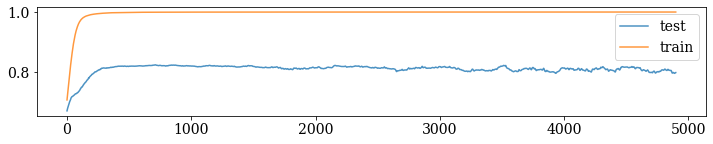

NameError: name 'last_history' is not defined

In [285]:
def dummy_forward_moving_avarage(signal, window):
    # This is slow version, you may use it for debug 
    new_signal = np.zeros(len(signal))
    for i in range(len(signal)):
        new_signal[i] = sum(signal[i-window if i > window else 0:i]) / window
    return new_signal


plt.figure(figsize=(12, 2))
#plt.plot(dummy_forward_moving_avarage(last_history, 100)[100:], alpha=0.8, label="old")
plt.plot(dummy_forward_moving_avarage(loss_history_test, 100)[100:], alpha=0.8, label="test")

plt.plot(dummy_forward_moving_avarage(loss_history_train, 100)[100:], alpha=0.8, label="train")

plt.legend()
plt.show()
if np.any(last_history != loss_history_test):
    last_history = loss_history_test

In [286]:
dummy_forward_moving_avarage(loss_history_test, 100),

(array([0.      , 0.005028, 0.010152, ..., 0.797438, 0.797688, 0.797862]),)

In [287]:
batch_size = 100
lag_backward = LAG_BACKWARD
lag_forward = LAG_FOREWARD

model_name  = "multi_patient_net"

#DUMP_DATA = False
#if DUMP_DATA:
#    import pickle
#    with open('results_data/model_' + model_name, 'wb') as dump_file:
#        pickle.dump({"model": model}, dump_file)


#LOAD_MODEL = True
#if LOAD_MODEL:
#    import pickle
#    with open('results_data/model_' + model_name, 'rb') as dump_file:
#        model = pickle.load(dump_file)["model"]

In [288]:
model

simple_net(
  (ica): Conv1d(64, 15, kernel_size=(1,), stride=(1,))
  (detector): envelope_detector(
    (conv_filtering): Conv1d(15, 15, kernel_size=(50,), stride=(1,), groups=15, bias=False)
    (conv_envelope): Conv1d(15, 15, kernel_size=(10,), stride=(1,), groups=15)
    (pre_envelope_batchnorm): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (relu): ReLU()
    (dropout1): Dropout(p=0.3, inplace=False)
    (dropout2): Dropout(p=0.3, inplace=False)
  )
  (features_batchnorm): BatchNorm1d(330, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (unmixed_batchnorm): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (wights_second): Linear(in_features=330, out_features=2, bias=True)
)

In [289]:
X_unmixed = []
X_preout = []

Y_predicted = []
for x_batch, _ in tqdm_notebook(batch_iterator(X_test, Y_test, batch_size)):
    #### Train
    model.eval()

    x_batch = Variable(torch.FloatTensor(x_batch)).cuda()
    y_predicted = model(x_batch).cpu().data.numpy()
    assert x_batch.shape[0]==y_predicted.shape[0]
    Y_predicted.append(y_predicted)
    X_unmixed.append(model.fuck_channels)
    X_preout.append(model.pre_out)
    

X_unmixed = np.concatenate(X_unmixed, axis = 0)
X_unmixed = X_unmixed[:, :, -1]
X_preout = np.concatenate(X_preout, axis=0)
Y_predicted = np.concatenate(Y_predicted, axis = 0)

print("Correlation   val", np.mean(Y_predicted.argmax(axis=1) == Y_test[:, 0]))


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



Correlation   val 0.8187022900763359


<AxesSubplot:>

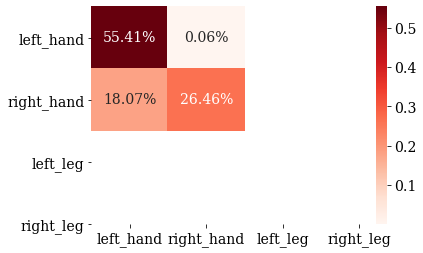

In [290]:
cm = sklearn.metrics.confusion_matrix(Y_test[:, 0], Y_predicted.argmax(axis=1))


group_names=["left_hand", "right_hand", "left_leg", "right_leg"]
import seaborn as sns
sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', xticklabels=group_names, yticklabels=group_names, cmap='Reds')

In [303]:
import sklearn
import sklearn.linear_model

ntr_embed = int(X_preout.shape[0] * 0.5)

X_embed_train = X_preout[:ntr_embed]
Y_embed_train = Y_test[:ntr_embed]

X_embed_test = X_preout[ntr_embed:]
Y_embed_test = Y_test[ntr_embed:]


linear_nodel = sklearn.linear_model.LogisticRegression(random_state=67)
linear_nodel.fit(X_embed_train, Y_embed_train[:, 0])
Y_embed_predicted = linear_nodel.predict_proba(X_embed_test)

print("Correlation   val", np.mean(Y_embed_predicted.argmax(axis=1) == Y_embed_test[:, 0]))


Correlation   val 0.4872773536895674


In [304]:
weights = sklearn.preprocessing.minmax_scale(np.abs(model.ica.weight[:, :, 0].cpu().detach().numpy()).transpose()).transpose()

In [305]:
mne.channels.Layout


mne.channels.layout.Layout

In [306]:

plt.plot(kek.pos[:,0],kek.pos[:,1],'.')

AttributeError: 'numpy.ndarray' object has no attribute 'pos'

In [307]:
kek=mne.channels.find_layout(fif_data.info)


In [308]:
#[aa.dig[i]['r'] for i in range(3,len(aa.dig))]

In [323]:
#fif_data.plot_sensors?

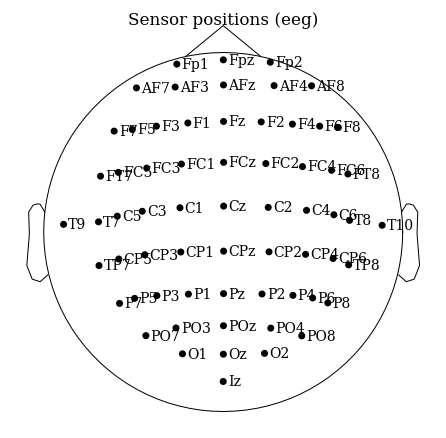

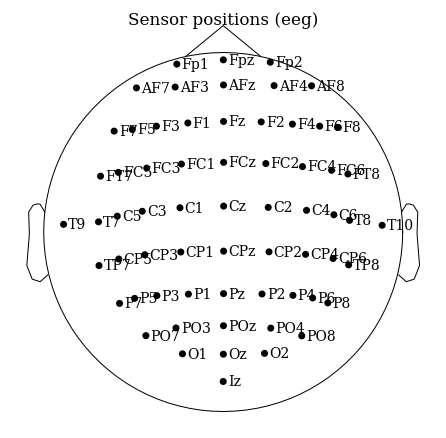

In [310]:
fif_data.plot_sensors(show_names=True)

In [334]:
#channel_names=channel_names[0]

In [336]:
CHANNELS=list(map(lambda x: str(x).lower(), channel_names))
CHANNELS

['fc5',
 'fc3',
 'fc1',
 'fcz',
 'fc2',
 'fc4',
 'fc6',
 'c5',
 'c3',
 'c1',
 'cz',
 'c2',
 'c4',
 'c6',
 'cp5',
 'cp3',
 'cp1',
 'cpz',
 'cp2',
 'cp4',
 'cp6',
 'fp1',
 'fpz',
 'fp2',
 'af7',
 'af3',
 'afz',
 'af4',
 'af8',
 'f7',
 'f5',
 'f3',
 'f1',
 'fz',
 'f2',
 'f4',
 'f6',
 'f8',
 'ft7',
 'ft8',
 't7',
 't8',
 't9',
 't10',
 'tp7',
 'tp8',
 'p7',
 'p5',
 'p3',
 'p1',
 'pz',
 'p2',
 'p4',
 'p6',
 'p8',
 'po7',
 'po3',
 'poz',
 'po4',
 'po8',
 'o1',
 'oz',
 'o2',
 'iz']

In [337]:
import mne
import mne.viz
import mne.io

MONTAGE_NAME = "standard_1005"
CHANNELS_DICT = {}

#assert len(mne.channels.read_montage(MONTAGE_NAME).ch_names) == len(mne.channels.read_montage(MONTAGE_NAME).get_pos2d())
aa=mne.channels.make_standard_montage(MONTAGE_NAME)
kek=mne.channels.find_layout(fif_data.info).pos[:,0:2]
kek_names=mne.channels.find_layout(fif_data.info).names

assert len(mne.channels.make_standard_montage(MONTAGE_NAME).ch_names) == len([aa.dig[i]['r'][:2] for i in range(3,len(aa.dig))])

#mne.channels.

for channel_name, coord in zip(aa.ch_names, [aa.dig[i]['r'][:2]  for i in range(3,len(aa.dig))]):
    assert channel_name.lower() not in CHANNELS_DICT
    CHANNELS_DICT[channel_name.lower()] = coord



import h5py
import numpy as np

CHANNELS = list(map(lambda x: str(x).lower(), channel_names))#[:64]
    
assert len(list(set(CHANNELS))) == len(CHANNELS) == 64
assert set(CHANNELS) - set(CHANNELS_DICT.keys()) == set()


def get_ossagtchi_spatial_patterns(X, temproral_weights, spatial_weights):
    patterns = np.zeros((spatial_weights.shape[0], spatial_weights.shape[1]))
    for i in range(temproral_weights.shape[0]):
        X_filtered = np.zeros(X.shape)
        for j in range(X_filtered.shape[1]):
            X_filtered[:, j] = np.convolve(X[:, j], temproral_weights[i, 0, :], mode="same")
            #print(np.convolve(X_filtered[:, j], temproral_weights[i, 0, :], mode="same"))
        patterns[:, i] = np.dot(np.cov(X_filtered, rowvar=False), spatial_weights[:, i].reshape((-1, 1)))[:, 0]
    return patterns

def get_interpretable(X, W, Y):
    y_col = Y.shape[1]
    return np.linalg.multi_dot([
        np.cov(X, rowvar=False), 
        W#, 
        #np.linalg.inv(np.cov(Y, rowvar=False).reshape((y_col, y_col)))
    ])



In [338]:
len(CHANNELS)

64

In [339]:

convs_weights = list(model.detector.conv_filtering.cpu().parameters())[0].detach().numpy()

In [340]:
num_of_ica=15

interpret_ossadtchi = get_ossagtchi_spatial_patterns(
    np.copy(X_train[:, :, 250]),
    convs_weights,
    np.repeat(np.copy(model.ica.weight.cpu().detach().numpy()[:, :, 0].transpose()), 1, axis=1),
).reshape(64, num_of_ica, 1)


interpret = get_interpretable(
    np.copy(X_train[:, :, 250]),
    np.copy(model.ica.weight.cpu().detach().numpy()[:, :, 0].transpose()),
    np.copy(X_unmixed)
)

raw_weights = model.ica.weight.cpu().detach().numpy()[:, :, 0].transpose()



In [341]:


####################

convs_weights = list(model.detector.conv_filtering.cpu().parameters())[0].detach().numpy()

COMPARISON_TOLERANCE = 10

ZOOM = 250

def get_freq_domain(signal, frequency):
    n = NPERSEQ
    ampletude = np.abs(np.fft.fft(signal,n))
    frequencies = np.fft.fftfreq(n , 1 / frequency)
    assert len(ampletude) == len(frequencies), f"{len(ampletude)}!={len(frequencies)}"
    end = int(len(frequencies)/2)
    return frequencies[:end], ampletude[:end]

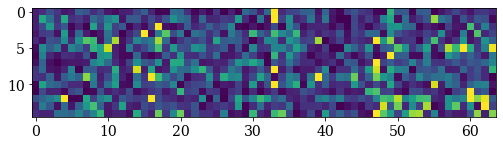

[(17, 6.188542), (8, 5.3609276), (20, 5.073566), (10, 5.0339713), (14, 4.919058), (16, 4.7837663), (19, 4.642707), (4, 4.6205373), (1, 4.571905), (28, 4.421636), (9, 4.32633), (11, 4.310784), (7, 4.2622037), (23, 3.6641047), (2, 3.6614482), (15, 3.5138962), (22, 3.422358), (6, 3.4082594), (18, 3.2545035), (27, 3.2192302), (25, 2.9250185), (26, 2.7061079), (21, 2.686791), (5, 2.6425617), (24, 2.63662), (3, 2.6176121), (29, 2.08319), (13, 2.0321672), (12, 1.8528588), (0, 1.3053937)]


In [342]:


####################

assert interpret_ossadtchi.shape[2] == 1


weights = sklearn.preprocessing.minmax_scale(np.abs(model.ica.weight[:, :, 0].cpu().detach().numpy()).transpose()).transpose()
plt.figure(figsize=(16, 2))
plt.imshow(weights)
plt.show()

print(sorted(zip(range(30), weights.sum(axis=0)), key=lambda x: x[1], reverse=True))

In [343]:
np.array([CHANNELS_DICT[channel] for channel in CHANNELS]),

(array([[-7.56159433e-02,  1.82572368e-02],
        [-5.89356606e-02,  2.22457957e-02],
        [-3.33565504e-02,  2.54724653e-02],
        [ 3.68311767e-04,  2.68228112e-02],
        [ 3.40637951e-02,  2.58904272e-02],
        [ 6.10031421e-02,  2.32315512e-02],
        [ 7.78871176e-02,  1.95228740e-02],
        [-7.86176695e-02, -1.34747658e-02],
        [-6.40046725e-02, -1.13908322e-02],
        [-3.54092446e-02, -9.77715463e-03],
        [ 3.92598212e-04, -8.97717089e-03],
        [ 3.68918929e-02, -9.42480532e-03],
        [ 6.57280308e-02, -1.06745779e-02],
        [ 8.17277055e-02, -1.25117299e-02],
        [-7.79440145e-02, -4.55867338e-02],
        [-6.22400860e-02, -4.60353475e-02],
        [-3.47776991e-02, -4.63125851e-02],
        [ 3.77810901e-04, -4.63381447e-02],
        [ 3.75889530e-02, -4.60983160e-02],
        [ 6.52324110e-02, -4.56714426e-02],
        [ 8.15963824e-02, -4.51466399e-02],
        [-2.88271284e-02,  8.21793550e-02],
        [ 1.09974505e-04,  8.641

In [344]:
channel

NameError: name 'channel' is not defined

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:78: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


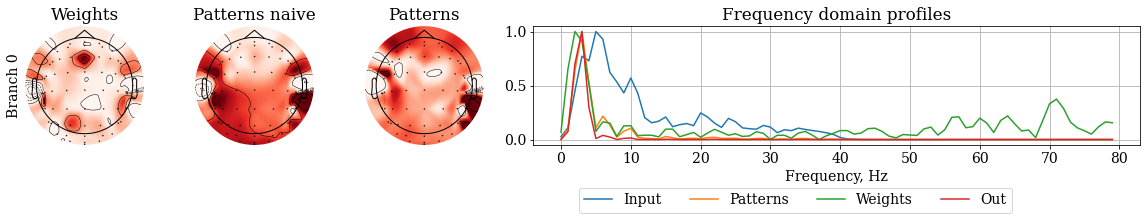

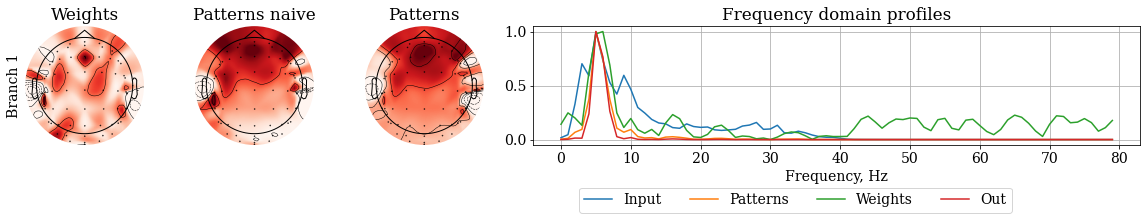

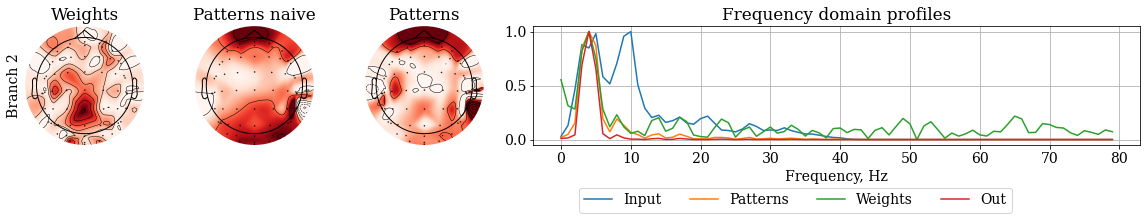

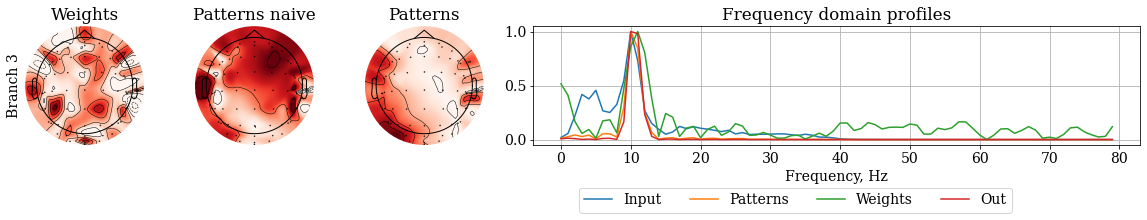

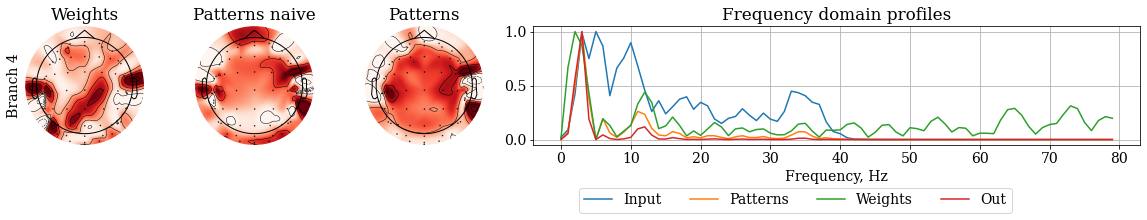

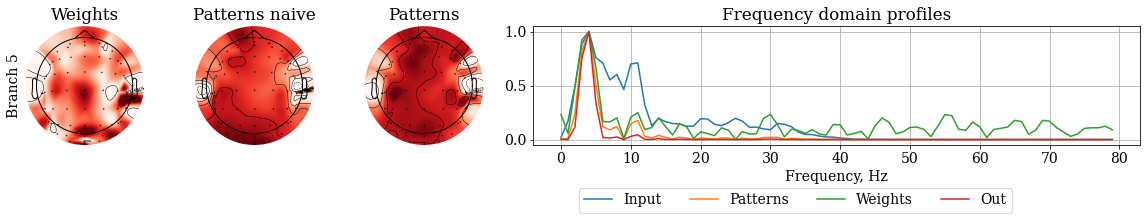

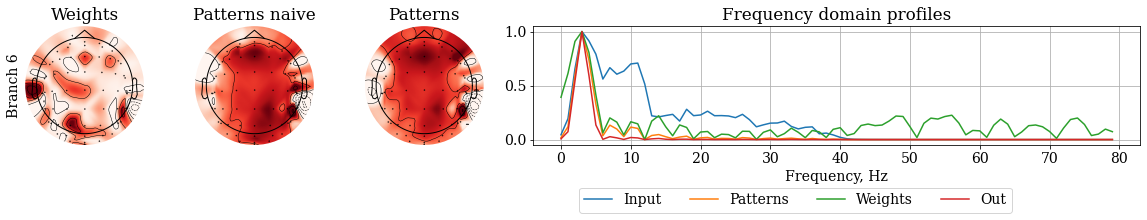

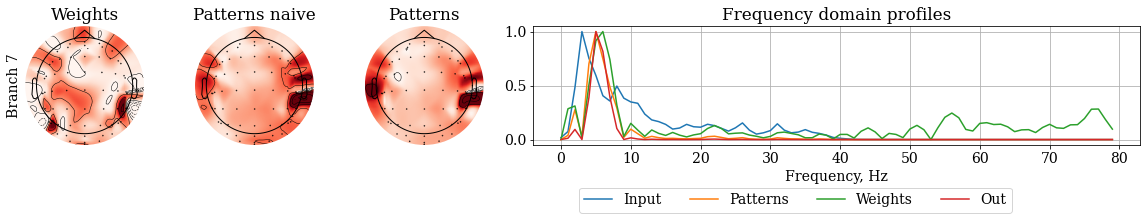

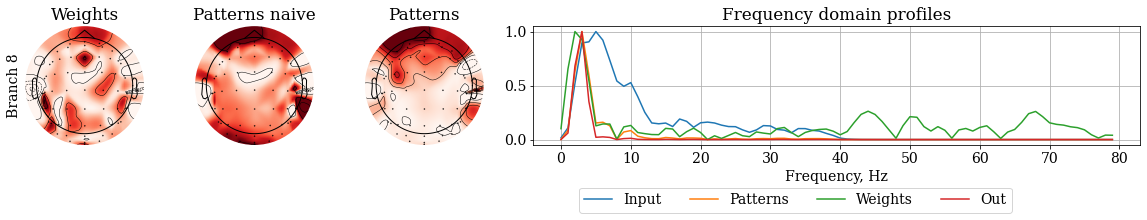

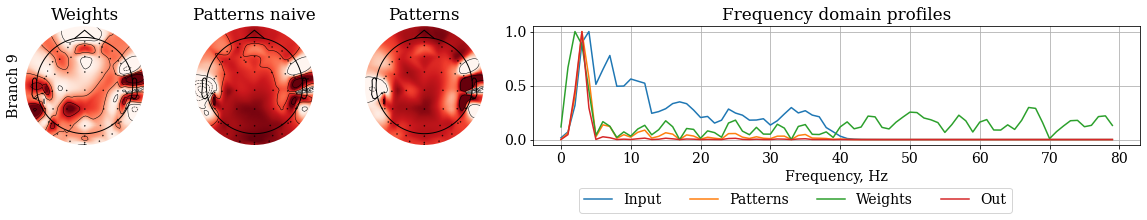

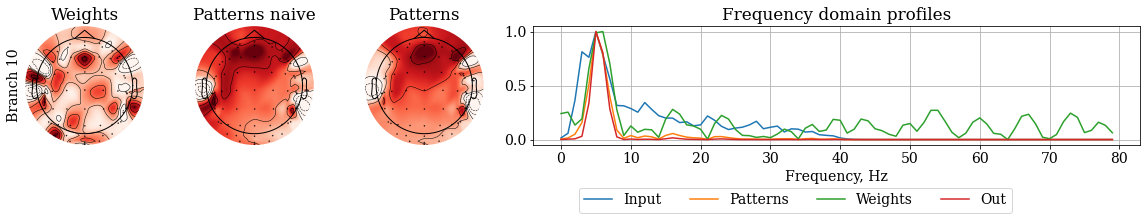

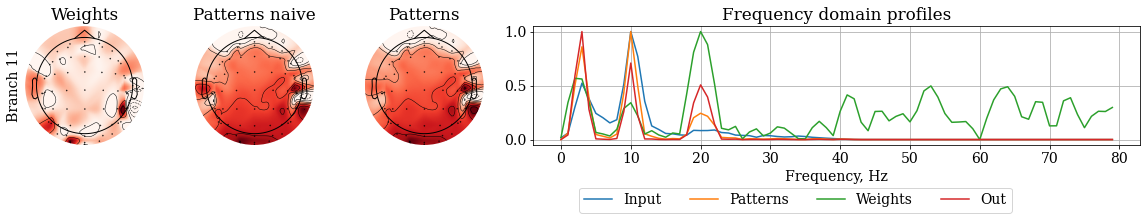

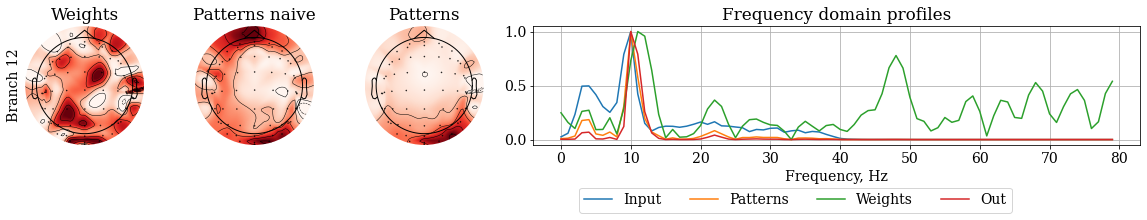

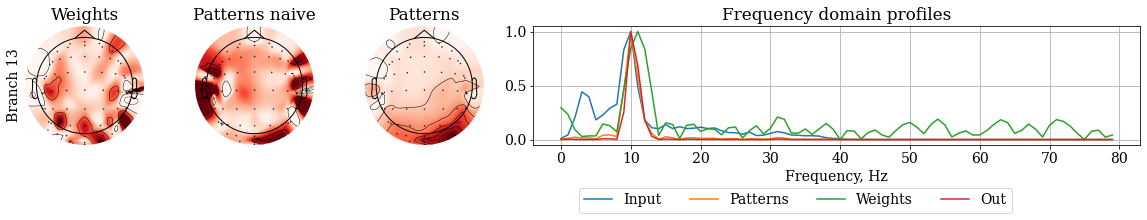

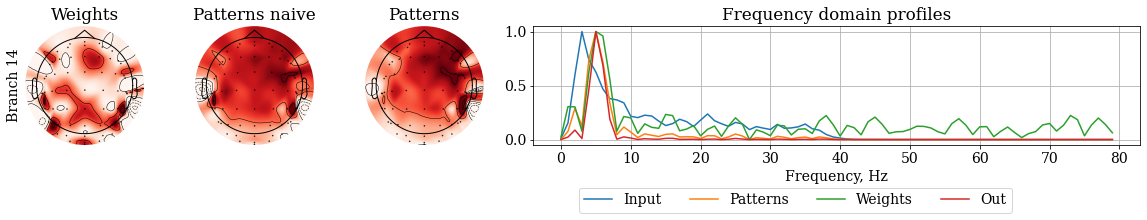

In [345]:

NPERSEQ=160


for i in range(interpret_ossadtchi.shape[1]):
    for j in range(interpret_ossadtchi.shape[2]):
        branches = raw_weights.shape[1]

        FINAL_FUGURE, FINAL_AXIS = plt.subplots(1, 4, gridspec_kw={'width_ratios': [1, 1, 1, 5],'height_ratios': [1]})
        #FINAL_FUGURE.suptitle(nammeee)
        FINAL_FUGURE.set_figwidth(20)
        FINAL_FUGURE.set_figheight(2)
        plt.rc('font', family='serif', size=14)

        plt.rc('ytick', labelsize=14)
        plt.setp(FINAL_AXIS[0], ylabel=f'Branch {i}')
            

        plt.setp(FINAL_AXIS[3], xlabel='Frequency, Hz')


        FINAL_AXIS[0].set_title("Weights")
        FINAL_AXIS[1].set_title("Patterns naive")
        FINAL_AXIS[2].set_title("Patterns")
        FINAL_AXIS[3].set_title("Frequency domain profiles")

        weights = convs_weights[i, j, :]
        
        frequencies_input, spectrum_input = scipy.signal.welch(X_unmixed[:, i], FREQUENCY, nperseg=NPERSEQ, detrend='linear')
        frequencies_input = frequencies_input[:-1]
        spectrum_input = spectrum_input[:-1]

        frequencies, ampletude = get_freq_domain(weights, FREQUENCY)

        assert len(frequencies_input) == len(frequencies), f"{len(frequencies_input)}!={len(frequencies)}"
        assert(
            list(np.round(frequencies_input, COMPARISON_TOLERANCE)) ==\
            list(np.round(frequencies, COMPARISON_TOLERANCE))
        )

        recovered = np.power(sklearn.preprocessing.minmax_scale(ampletude), 1) * sklearn.preprocessing.minmax_scale(spectrum_input)
        out_spectrum = np.power(sklearn.preprocessing.minmax_scale(ampletude), 2) * sklearn.preprocessing.minmax_scale(spectrum_input)

        frequencies, ampletude = get_freq_domain(weights, FREQUENCY)
        
        figure = FINAL_AXIS[3]
        
        figure.plot(frequencies_input[:ZOOM], sklearn.preprocessing.minmax_scale(spectrum_input)[:ZOOM], label='Input')
        figure.plot(frequencies[:ZOOM], sklearn.preprocessing.minmax_scale(recovered)[:ZOOM], label='Patterns')
        figure.plot(frequencies[:ZOOM], sklearn.preprocessing.minmax_scale(ampletude)[:ZOOM], label = 'Weights')
        figure.plot(frequencies[:ZOOM], sklearn.preprocessing.minmax_scale(out_spectrum)[:ZOOM], label='Out')
        figure.grid()
        figure.legend(bbox_to_anchor=(0.8, -0.3), ncol=4)
        
        #
        #plt.show()
        
        
        mne.viz.plot_topomap(
            sklearn.preprocessing.minmax_scale(np.abs(interpret_ossadtchi[:, i, j]).transpose()),
            np.array([CHANNELS_DICT[channel] for channel in CHANNELS]),
            axes=FINAL_AXIS[2],
            show=False
        )
        
        mne.viz.plot_topomap(
            sklearn.preprocessing.minmax_scale(np.abs(interpret[:, i]).transpose()),
            np.array([CHANNELS_DICT[channel] for channel in CHANNELS]),
            axes=FINAL_AXIS[1],
            show=False
        )
        mne.viz.plot_topomap(
            sklearn.preprocessing.minmax_scale(np.abs(raw_weights[:, i]).transpose()),
            np.array([CHANNELS_DICT[channel] for channel in CHANNELS]),
            axes=FINAL_AXIS[0],
            show=False
        )

FINAL_FUGURE.show()

In [460]:
mne.viz.plot_topomap(
            sklearn.preprocessing.minmax_scale(np.abs(interpret_ossadtchi[:, i, j]).transpose()),
            np.array([CHANNELS_DICT[channel] for channel in CHANNELS]),
            axes=FINAL_AXIS[2],
            show=False
        )
plt.show()

<Figure size 432x288 with 0 Axes>

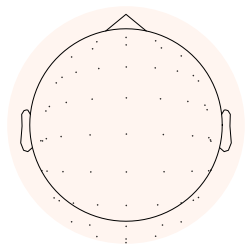

(<matplotlib.image.AxesImage at 0x7f9b8ed5cbd0>,
 <matplotlib.contour.QuadContourSet at 0x7f9b8ed5cf50>)

In [461]:
mne.viz.plot_topomap(
            np.zeros(64),
            np.array([CHANNELS_DICT[channel] for channel in CHANNELS]),
            #axes=FINAL_AXIS[2],
            show=True
        )

In [178]:
CHANNELS_DICT

{'fp1': array([-0.02882713,  0.08217935]),
 'fpz': array([0.00010997, 0.08641959]),
 'fp2': array([0.02925371, 0.08313789]),
 'af9': array([-0.04795672,  0.06276009]),
 'af7': array([-0.05370409,  0.06715222]),
 'af5': array([-0.04448993,  0.07135338]),
 'af3': array([-0.03300283,  0.07524597]),
 'af1': array([-0.01808919,  0.07824946]),
 'afz': array([0.00022651, 0.0790984 ]),
 'af2': array([0.01940986, 0.07863902]),
 'af4': array([0.03497277, 0.07611636]),
 'af6': array([0.04561964, 0.0722794 ]),
 'af8': array([0.05458897, 0.06821436]),
 'af10': array([0.04939079, 0.06254719]),
 'f9': array([-0.06865024,  0.04078977]),
 'f7': array([-0.0688079 ,  0.04159475]),
 'f5': array([-0.06313085,  0.04704059]),
 'f3': array([-0.04920336,  0.05201138]),
 'f1': array([-0.02692642,  0.05575218]),
 'fz': array([0.00030574, 0.05730034]),
 'f2': array([0.02890302, 0.05640909]),
 'f4': array([0.05076278, 0.05318026]),
 'f6': array([0.06650784, 0.04879783]),
 'f8': array([0.07153053, 0.04350182]),
 'f

In [144]:
sklearn.preprocessing.minmax_scale(np.abs(interpret_ossadtchi[:, i, j]).transpose()).shape

(64,)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])